<a href="https://colab.research.google.com/github/vipin-jangra/2048-JAVA/blob/master/Face_age_estimation_CNN_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.resnet50 import preprocess_input

In [18]:
# # Define a function to preprocess images
# def preprocess_image(image_path):
#     image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
#     image = cv2.resize(image, (224, 224))
#     image = image.astype('float32') / 255.0
#     # Add channel dimension for grayscale images
#     image = np.expand_dims(image, axis=-1)
#     return image

In [31]:
def preprocess_image(image_path):
    # Read grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to (224, 224)
    image = cv2.resize(image, (224, 224))
    # Convert grayscale to RGB by stacking the single channel
    image_rgb = np.stack((image,) * 3, axis=-1)
    # Preprocess image for ResNet50 model
    image_rgb = preprocess_input(image_rgb)
    return image_rgb

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define age group conversion
def age_to_group(age):
    return age // 3

Image preprocessing

In [32]:
# Load and preprocess the dataset
image_dir = '/content/drive/MyDrive/Dataset/part1'
image_paths = []
age_labels = []

for filename in os.listdir(image_dir):
  if filename.endswith(".jpg"):
    age = int(filename.split('_')[0])
    image_path = os.path.join(image_dir, filename)
    image_paths.append(image_path)
    age_labels.append(age)

images = np.array([preprocess_image(img_path) for img_path in image_paths])
age_groups = np.array([age_to_group(age) for age in age_labels])

In [33]:
print(f'number of images : {len(images)}')

number of images : 9931


In [34]:
# Function to convert age group index to interval string
def age_group_to_interval(group_index):
    start = group_index * 3
    end = (group_index + 1) * 3
    return f"{start}-{end}"

In [35]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/drive/MyDrive/Dataset/part1/28_1_0_20...,27-30
1,/content/drive/MyDrive/Dataset/part1/35_0_0_20...,33-36
2,/content/drive/MyDrive/Dataset/part1/38_0_4_20...,36-39
3,/content/drive/MyDrive/Dataset/part1/50_1_0_20...,48-51
4,/content/drive/MyDrive/Dataset/part1/20_1_2_20...,18-21
5,/content/drive/MyDrive/Dataset/part1/35_0_4_20...,33-36
6,/content/drive/MyDrive/Dataset/part1/57_0_0_20...,57-60
7,/content/drive/MyDrive/Dataset/part1/51_0_0_20...,51-54
8,/content/drive/MyDrive/Dataset/part1/36_1_0_20...,36-39
9,/content/drive/MyDrive/Dataset/part1/39_0_0_20...,39-42


Exploratory data analysis

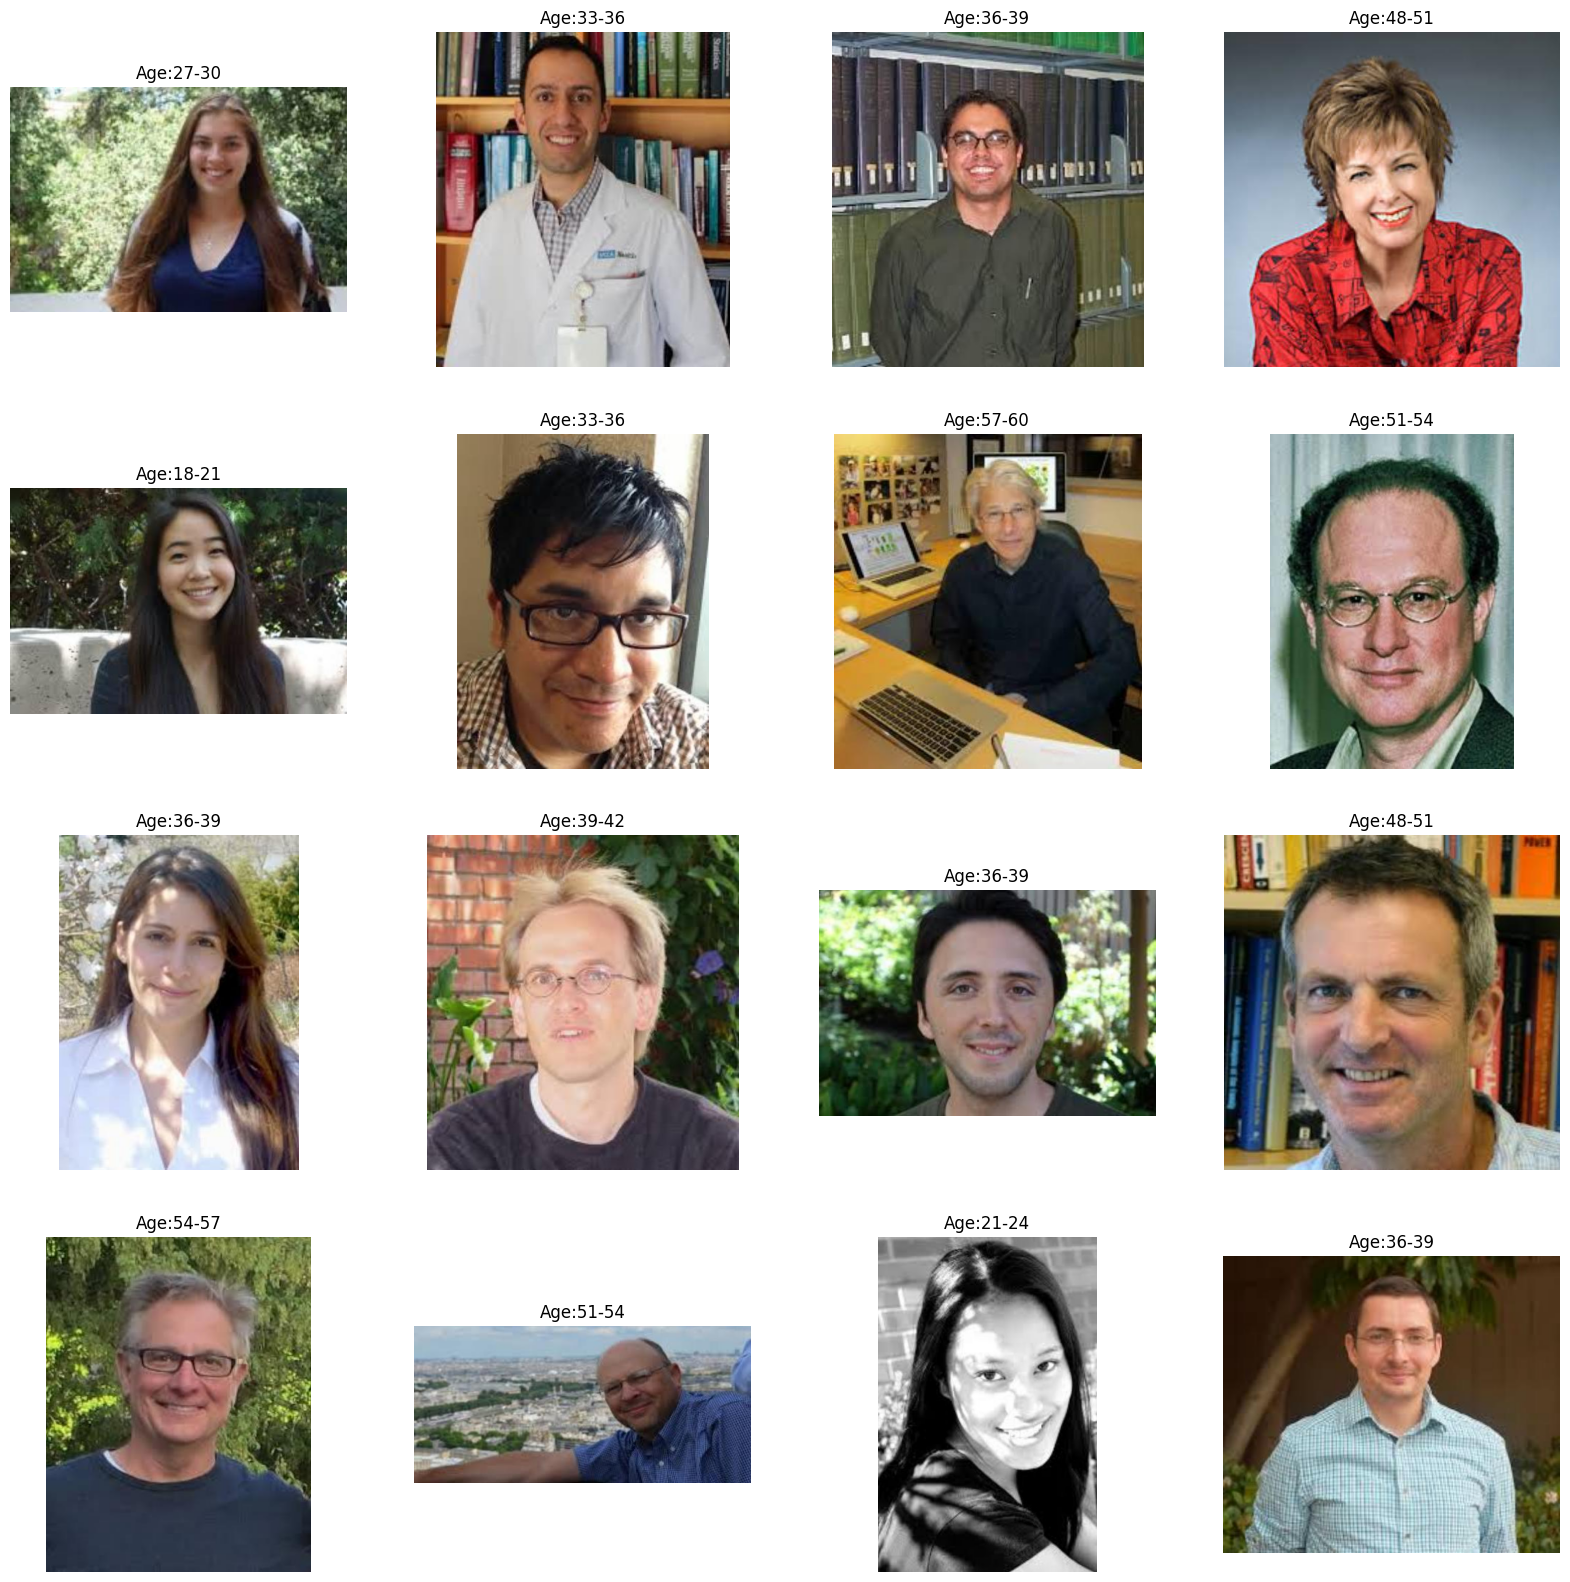

In [36]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

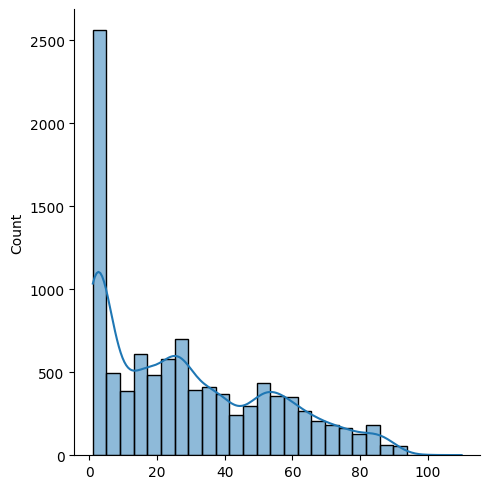

In [37]:
#age distribution
sns.displot(data=age_labels,kde=True)

In [38]:
# Example: Convert age groups to categorical if not already
age_group_indices = [age // 3 for age in age_groups]  # Convert ages to 3-year interval indices
num_classes = np.max(age_groups) + 1
age_groups_categorical = to_categorical(age_groups, num_classes)
print(num_classes)

37


Split data

In [39]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_groups_categorical, test_size=0.2, random_state=42)


Compile the model

In [41]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(num_classes, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


SetUp Callbacks

In [42]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_age_group_model.h5', save_best_only=True, monitor='val_loss')


Train the model

In [43]:
model.fit(train_images, train_age_groups, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
199/199 [==============================] - ETA: 0s - loss: 2.9408 - accuracy: 0.1976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - 112s 382ms/step - loss: 2.9408 - accuracy: 0.1976 - val_loss: 117.9438 - val_accuracy: 0.1794
Epoch 2/50
199/199 [==============================] - 68s 344ms/step - loss: 2.5326 - accuracy: 0.2530 - val_loss: 2.9829 - val_accuracy: 0.1894
Epoch 3/50
199/199 [==============================] - 67s 338ms/step - loss: 2.3303 - accuracy: 0.2812 - val_loss: 3.3353 - val_accuracy: 0.2410
Epoch 4/50
199/199 [==============================] - 68s 343ms/step - loss: 2.1646 - accuracy: 0.3106 - val_loss: 2.4901 - val_accuracy: 0.2398
Epoch 5/50
199/199 [==============================] - 68s 344ms/step - loss: 2.0373 - accuracy: 0.3342 - val_loss: 2.4756 - val_accuracy: 0.2637
Epoch 6/50
199/199 [==============================] - 67s 338ms/step - loss: 1.8803 - accuracy: 0.3769 - val_loss: 3.6228 - val_accuracy: 0.2599
Epoch 7/50
199/199 [==============================] - 67s 338ms/step - loss: 1.7797 - accuracy: 0.3928 - val_loss: 2.9105 - val_accuracy: 

Load best model and evaluate

In [44]:
# Load the best model
model.load_weights('best_age_group_model.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


63/63 [==============================] - 7s 105ms/step - loss: 2.4748 - accuracy: 0.2828
Test Accuracy: 28.28%
